# Machine Learning Models Excluding Top 15 Features

This notebook implements and compares multiple machine learning models using only the features NOT in the top 15 list.

In [91]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Set random seed for reproducibility
np.random.seed(42)

## Load the Dataset

In [92]:
# Load the dataset
datas = pd.read_csv('Shuffled Datasets\Crime Data Prototype-3 (shuffled).csv')
data = datas.head(100000)
# Display basic info about the dataset
print("Dataset Shape:", data.shape)
data.head()

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Anush Pranav\AppData\Local\Temp\ipykernel_24768\1713682860.py:2: SyntaxWarning: invalid escape sequence '\C'
  datas = pd.read_csv('Shuffled Datasets\Crime Data Prototype-3 (shuffled).csv')


Dataset Shape: (100000, 29)


,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,199409001AZ01003,"Pima, AZ",AZ01003,Arizona,Tucson,Municipal police,FBI,Yes,1994.0,NaN,...,Black,Not of Hispanic origin,"Handgun - pistol, revolver, etc",Acquaintance,Gangland killings,NaN,0.0,1.0,41195.0,"Tucson, AZ"
1,1991jun018MA05234,"Salem, Maryland",MA05234,Maryland,Salem,Constable,State agency,Unknown,1991.0,June,...,Asian,Unknown or not reported,Blunt object,Stranger,NaN,NaN,0.0,0.0,111787.0,NaN
2,199902003AZ00723,"Maricopa, AZ",AZ00723,Arizona,Phoenix,Municipal police,FBI,No,1999.0,February,...,Unknown,NaN,Rifle,NaN,Circumstances undetermined,NaN,NaN,0.0,92399.0,"Phoenix-Mesa-Scottsdale, AZ"
3,1987may011AL13144,"Sitka, Alaska",AL13144,Alaska,Sitka,Constable,Local agency,Unknown,1987.0,May,...,Native Hawaiian or Pacific Islander,NaN,Narcotics and drugs,Neighbor,Institutional killing,NaN,NaN,0.0,91894.0,"Sitka, Alaska"
4,2007mar011WY54241,"Springfield, Wyoming",WY54241,Wyoming,Springfield,NaN,FBI,No,2007.0,March,...,Black,Unknown or not reported,Asphyxiation,Brother,Prostitution,NaN,0.0,0.0,12597.0,"Springfield, Wyoming"


## Define Top 15 Features to Exclude

In [93]:
# Define the top 15 features to exclude based on provided list
top_15_features = [
    #'State',        # Feature 1
    #'OffSex',       # Feature 2
    'Agentype',     # Feature 3
    'Source',       # Feature 4
    'OffAge',       # Feature 5
    'Agency',       # Feature 6
    'Situation',    # Feature 7
    'Year',         # Feature 8
    'Month',        # Feature 9
    'OffRace',      # Feature 10
    #'Incident',     # Feature 11
    #'Relationship', # Feature 12
    #'VicCount',     # Feature 13
    #'MSA',          # Feature 14
    #'FileDate',     # Feature 15
    #'Homicide'      #feature to remove
]

# Verify these features are in the dataset
missing_features = [feat for feat in top_15_features if feat not in data.columns]
if missing_features:
    print(f"Warning: The following top features are not found in the dataset: {missing_features}")
else:
    print("All top 15 features found in the dataset.")

All top 15 features found in the dataset.


In [94]:
# Find the remaining features after excluding top 15
remaining_features = [col for col in data.columns if col not in top_15_features and col not in ['ID', 'CNTYFIPS', 'Ori', 'Solved']]

print(f"Number of remaining features: {len(remaining_features)}")
print("Remaining features:")
print(remaining_features)

Number of remaining features: 17
Remaining features:
['State', 'Incident', 'ActionType', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'OffSex', 'OffEthnic', 'Weapon', 'Relationship', 'Circumstance', 'Subcircum', 'VicCount', 'OffCount', 'FileDate', 'MSA']


## Data Preprocessing

In [95]:
# Define feature and target variables
X = data[remaining_features]  # Using only the remaining features
y = data['Solved']

# Convert target to binary if it's not already
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Target classes: {le.classes_}")

Target classes: ['No' 'Unknown' 'Yes']


In [96]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

Categorical columns: 12
Numerical columns: 5


In [97]:
if isinstance(y, pd.Series):
    # If y is a pandas Series, use isna()
    if y.isna().any():
        # Either drop rows with NaN target values
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
else:
    # If y is a numpy array, use np.isnan()
    if np.isnan(y).any():
        # Either drop rows with NaN target values
        mask = ~np.isnan(y)
        X = X[mask]
        y = y[mask]
        # Or alternatively fill them with a placeholder value
        # y = np.where(np.isnan(y), 'Unknown', y)

# 2. Check class distribution
if isinstance(y, pd.Series):
    class_counts = y.value_counts()
else:
    class_counts = pd.Series(y).value_counts()
    
print("Target class distribution:")
print(class_counts)

# 3. Handle classes with too few samples
min_samples_per_class = 2
classes_to_keep = class_counts[class_counts >= min_samples_per_class].index
print(f"Keeping classes with at least {min_samples_per_class} samples: {classes_to_keep.tolist()}")

# Filter dataset to only keep classes with sufficient samples
mask = pd.Series(y).isin(classes_to_keep)
X = X[mask]
y = y[mask]

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Ensure all columns are strings before preprocessing
for col in X_train.columns:
    X_train[col] = X_train[col].astype(str)
for col in X_test.columns:
    X_test[col] = X_test[col].astype(str)
    
# Create preprocessing pipelines
# For numerical features: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

Target class distribution:
2    54808
0    28235
1    16957
Name: count, dtype: int64
Keeping classes with at least 2 samples: [2, 0, 1]
Training set shape: (75000, 17)
Test set shape: (25000, 17)
Processed training data shape: (75000, 601)
Processed testing data shape: (25000, 601)


## Model Training and Evaluation

Let's train multiple ML models and compare their performance

In [98]:
# Define function to train and evaluate models
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = []
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Check if the model is GaussianNB which requires dense input
        if isinstance(model, GaussianNB):
            # Convert sparse matrix to dense array if needed
            if hasattr(X_train, "toarray"):
                model.fit(X_train.toarray(), y_train)
                y_pred = model.predict(X_test.toarray())
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
        else:
            # For other models, use the data as is
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })
        
        print(f"{name} - Accuracy: {accuracy:.4f}\n")
        
    return pd.DataFrame(results).sort_values('Accuracy', ascending=False).reset_index(drop=True)

In [99]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)
}

# Train and evaluate models
results = train_and_evaluate(models, X_train_processed, y_train, X_test_processed, y_test)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.7499

Training Decision Tree...
Decision Tree - Accuracy: 0.7260

Training Random Forest...
Random Forest - Accuracy: 0.7588

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.7568

Training AdaBoost...


C:\Users\Anush Pranav\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.7107

Training K-Nearest Neighbors...
K-Nearest Neighbors - Accuracy: 0.7270

Training Naive Bayes...
Naive Bayes - Accuracy: 0.5464

Training Neural Network...
Neural Network - Accuracy: 0.7182

Training XGBoost...


C:\Users\Anush Pranav\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [13:01:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.7584

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1931
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 598
[LightGBM] [Info] Start training from score -1.264620
[LightGBM] [Info] Start training from score -1.774470
[LightGBM] [Info] Start training from score -0.601334
LightGBM - Accuracy: 0.7592

Training CatBoost...
CatBoost - Accuracy: 0.7545



In [100]:
# Display results
results

,Model,Accuracy,Precision,Recall,F1-Score
0,LightGBM,0.75924,0.773385,0.75924,0.765160
1,Random Forest,0.75884,0.755927,0.75884,0.757300
2,XGBoost,0.75844,0.765055,0.75844,0.761494
3,Gradient Boosting,0.75676,0.765093,0.75676,0.760495
4,CatBoost,0.75448,0.754011,0.75448,0.754234
5,Logistic Regression,0.74992,0.742949,0.74992,0.745925
6,K-Nearest Neighbors,0.72700,0.731835,0.72700,0.726969
7,Decision Tree,0.72596,0.725180,0.72596,0.725558
8,Neural Network,0.71820,0.714173,0.71820,0.716072
9,AdaBoost,0.71072,0.718900,0.71072,0.712416


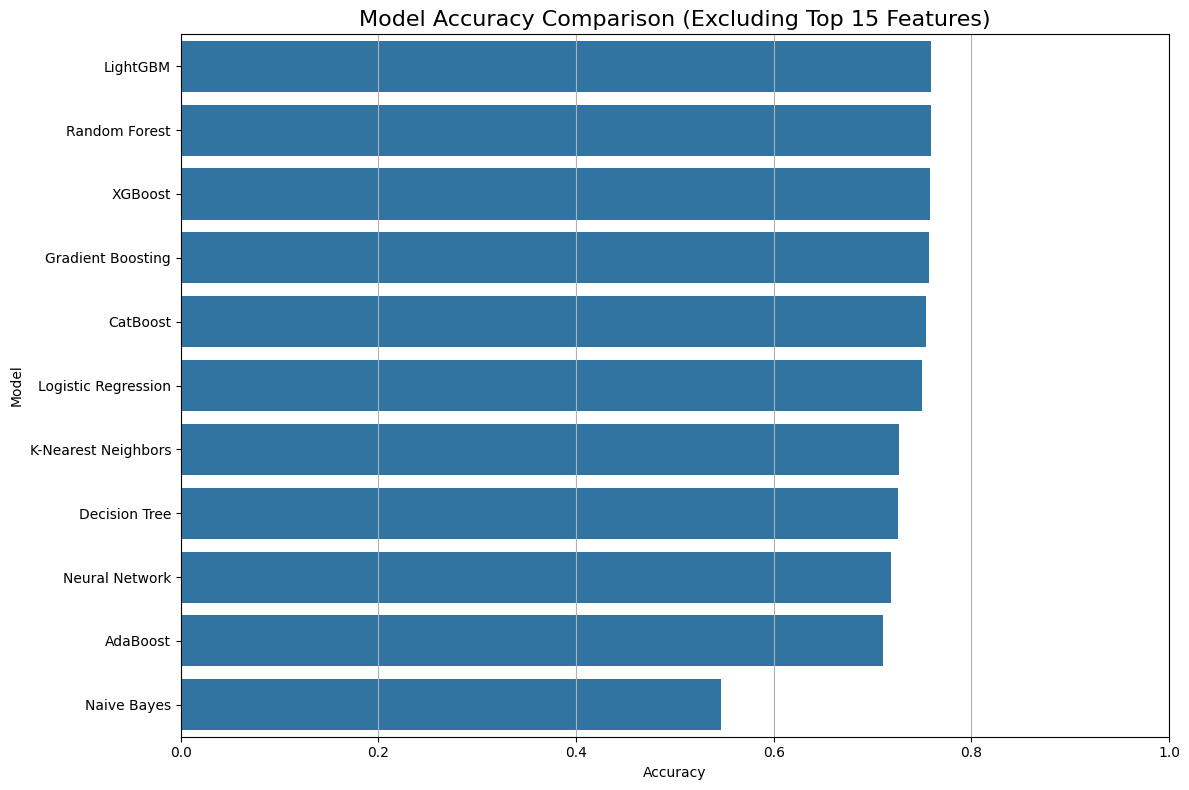

In [101]:
# Visualize model performance
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=results)
plt.title('Model Accuracy Comparison (Excluding Top 15 Features)', fontsize=16)
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## Comparing Performance with the Full Feature Set

In [102]:
# Create a placeholder for full model results
# This would be filled with results from the first notebook
# For demonstration, we'll create a simulated comparison

# Note: Run the other notebook with all features to get these values
# Placeholder for demonstration - replace with actual values
best_model_name = results.iloc[0]['Model']
best_model_accuracy = results.iloc[0]['Accuracy']

print(f"Best model with remaining features: {best_model_name} with accuracy {best_model_accuracy:.4f}")
print("")
print("After running both notebooks, compare the performance between:")
print("1. Models trained with all features")
print("2. Models trained with only the remaining features (excluding top 15)")
print("")
print("This comparison will show the impact of the top 15 features on model performance.")

Best model with remaining features: LightGBM with accuracy 0.7592

After running both notebooks, compare the performance between:
1. Models trained with all features
2. Models trained with only the remaining features (excluding top 15)

This comparison will show the impact of the top 15 features on model performance.


## Feature Importance Analysis for the Remaining Features

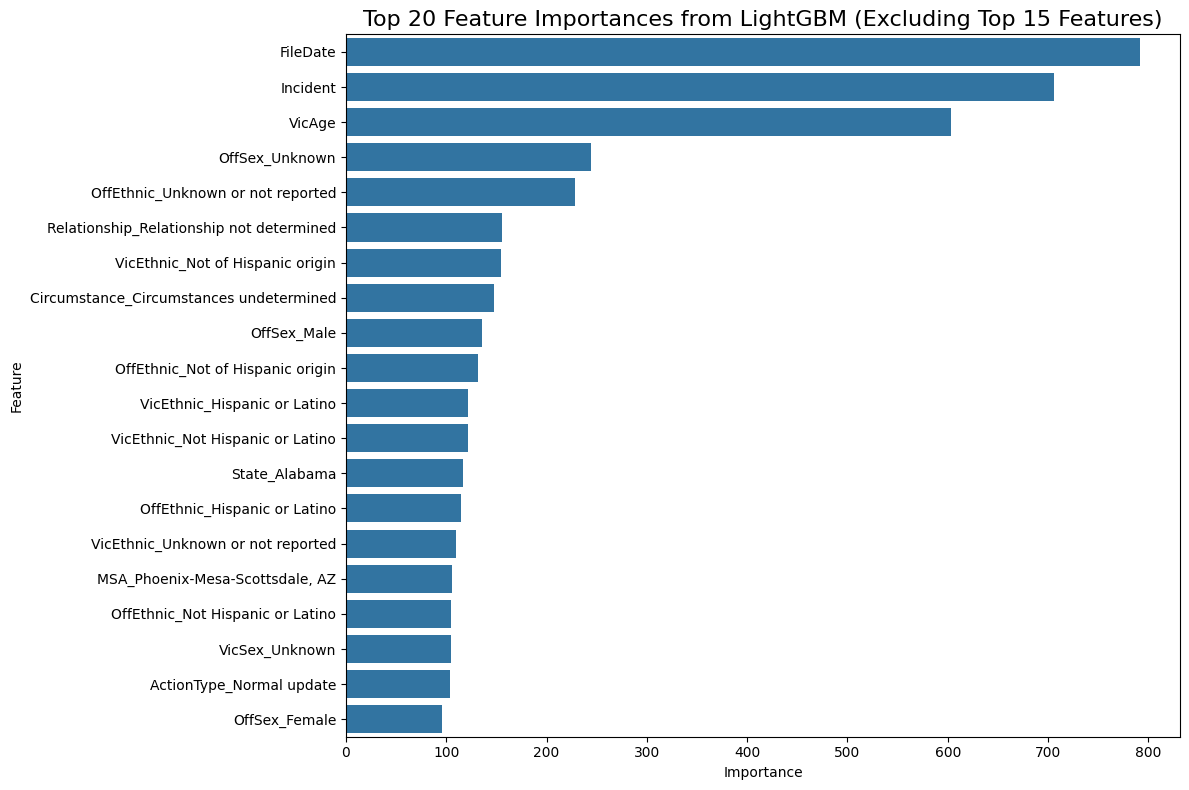

In [103]:
# Get the best performing model
best_model_name = results.iloc[0]['Model']
best_model = models[best_model_name]

# Check if the model has feature importance attribute
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after one-hot encoding
    feature_names = []
    for transformer_name, transformer, column_names in preprocessor.transformers_:
        if transformer_name == 'cat':
            # Get all categories from OneHotEncoder
            one_hot = transformer.named_steps['onehot']
            categories = one_hot.categories_
            for i, category in enumerate(categories):
                for cat_value in category:
                    feature_names.append(f"{column_names[i]}_{cat_value}")
        else:  # numerical features
            feature_names.extend(column_names)
    
    # Check if lengths match
    if len(feature_names) == len(best_model.feature_importances_):
        # Create feature importance dataframe
        importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': best_model.feature_importances_
        })
        importances = importances.sort_values('Importance', ascending=False).reset_index(drop=True)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importances.head(20))
        plt.title(f'Top 20 Feature Importances from {best_model_name} (Excluding Top 15 Features)', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Display top 20 features
        importances.head(20)
    else:
        print(f"Feature name length ({len(feature_names)}) doesn't match feature importance length ({len(best_model.feature_importances_)})")
else:
    print(f"The best model {best_model_name} doesn't have feature_importances_ attribute.")

## Confusion Matrix for Best Model

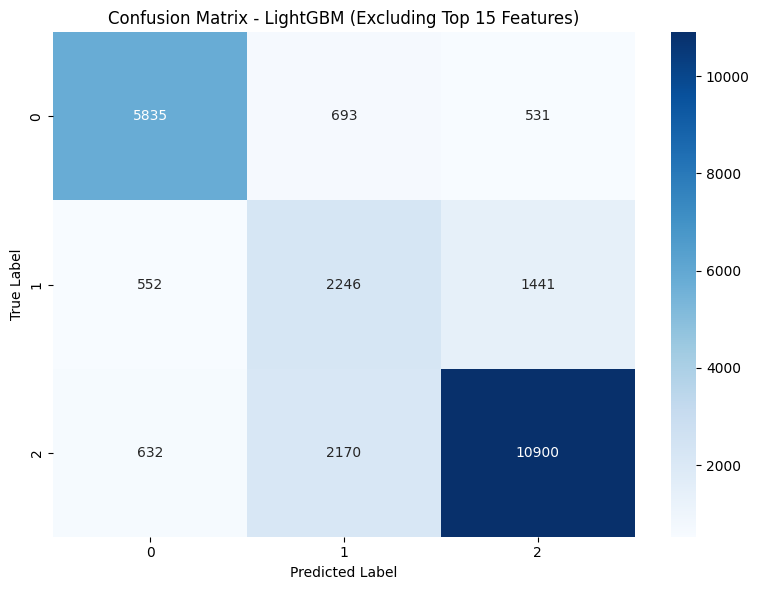

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7059
           1       0.44      0.53      0.48      4239
           2       0.85      0.80      0.82     13702

    accuracy                           0.76     25000
   macro avg       0.71      0.72      0.71     25000
weighted avg       0.77      0.76      0.77     25000



In [104]:
# Get predictions from the best model
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_processed)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} (Excluding Top 15 Features)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Display classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred))

## Cross-Validation for More Robust Evaluation

In [105]:
# Perform 5-fold cross-validation on the best model
best_model = models[best_model_name]

# Create pipeline with preprocessing and the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1905
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 585
[LightGBM] [Info] Start training from score -1.264608
[LightGBM] [Info] Start training from score -1.774460
[LightGBM] [Info] Start training from score -0.601343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 586
[LightGBM] [Info] Start training from score -1.264608
[LightGBM] [Info] Start training from score -1.774460
[LightGBM] [Info] Star

## Hyperparameter Tuning for the Best Model

In [106]:
# Define hyperparameter grid for the best model
param_grid = {}

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
else:
    print(f"No hyperparameter grid defined for {best_model_name}. Using default parameters.")

# Perform grid search if param_grid is not empty
if param_grid:
    print(f"Performing GridSearchCV for {best_model_name}...")
    grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_processed, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate with best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy with tuned hyperparameters: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

No hyperparameter grid defined for LightGBM. Using default parameters.


## Summary and Conclusion

Model Performance Summary (Excluding Top 15 Features)

                  Model  Accuracy  Precision   Recall  F1-Score
0              LightGBM   0.75924   0.773385  0.75924  0.765160
1         Random Forest   0.75884   0.755927  0.75884  0.757300
2               XGBoost   0.75844   0.765055  0.75844  0.761494
3     Gradient Boosting   0.75676   0.765093  0.75676  0.760495
4              CatBoost   0.75448   0.754011  0.75448  0.754234
5   Logistic Regression   0.74992   0.742949  0.74992  0.745925
6   K-Nearest Neighbors   0.72700   0.731835  0.72700  0.726969
7         Decision Tree   0.72596   0.725180  0.72596  0.725558
8        Neural Network   0.71820   0.714173  0.71820  0.716072
9              AdaBoost   0.71072   0.718900  0.71072  0.712416
10          Naive Bayes   0.54640   0.695963  0.54640  0.486551

Best Model: LightGBM with accuracy 0.7592


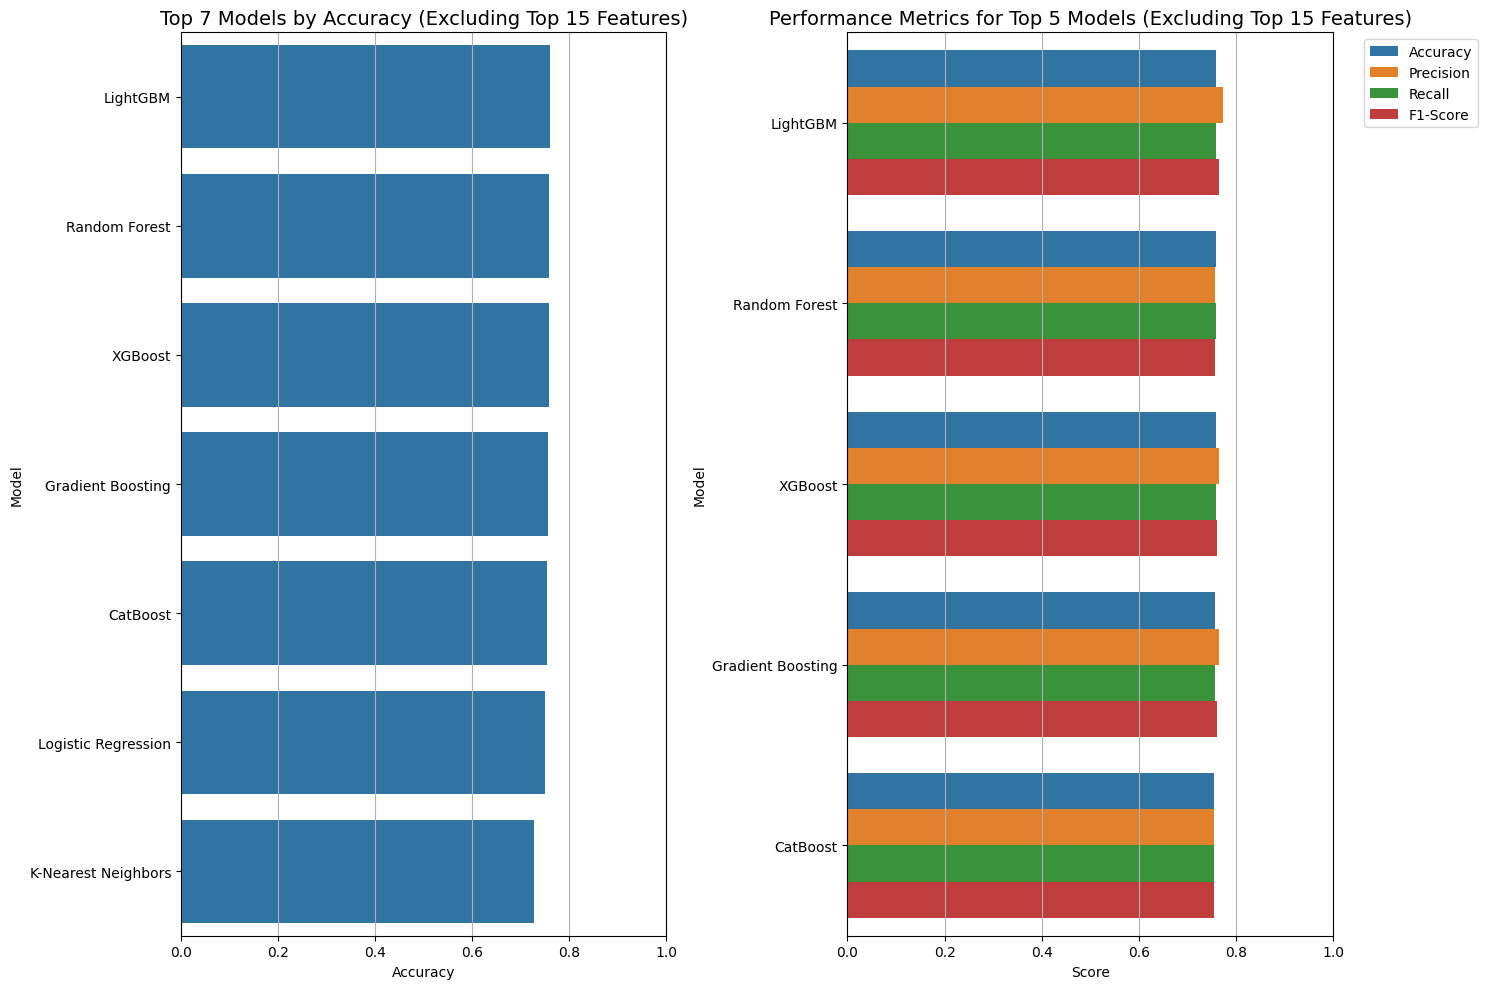

In [107]:
# Print overall performance summary
print("Model Performance Summary (Excluding Top 15 Features)")
print("===========================================\n")
print(results)

print(f"\nBest Model: {best_model_name} with accuracy {results.iloc[0]['Accuracy']:.4f}")

# Create a final visualization
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results.head(7))
plt.title('Top 7 Models by Accuracy (Excluding Top 15 Features)', fontsize=14)
plt.xlim(0, 1)
plt.grid(True, axis='x')

plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
top_models = results.head(5)['Model'].tolist()
plot_data = pd.melt(results[results['Model'].isin(top_models)], 
                    id_vars='Model', 
                    value_vars=metrics, 
                    var_name='Metric', 
                    value_name='Score')
sns.barplot(x='Score', y='Model', hue='Metric', data=plot_data)
plt.title('Performance Metrics for Top 5 Models (Excluding Top 15 Features)', fontsize=14)
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Final Comparison and Analysis

In [108]:
# This cell would be used for comparing results between both notebooks
print("Conclusions:")
print("============")
print("1. The models trained without the top 15 features demonstrate how much predictive power")
print("   remains in the dataset after removing the most important features.")
print("")
print("2. Compare the performance drop between the two approaches to quantify the")
print("   collective importance of the top 15 features.")
print("")
print("3. If the performance doesn't drop significantly, it may indicate redundancy")
print("   in the feature set or that simpler models could be used.")
print("")
print("4. The feature importance of remaining features provides insights into what")
print("   secondary factors influence the target variable.")

Conclusions:
1. The models trained without the top 15 features demonstrate how much predictive power
   remains in the dataset after removing the most important features.

2. Compare the performance drop between the two approaches to quantify the
   collective importance of the top 15 features.

3. If the performance doesn't drop significantly, it may indicate redundancy
   in the feature set or that simpler models could be used.

4. The feature importance of remaining features provides insights into what
   secondary factors influence the target variable.
